# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [24]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   book    1206 non-null   object
 1   dex     1206 non-null   int64 
 2   cha     1206 non-null   int64 
 3   level   1206 non-null   int64 
 4   str     1206 non-null   int64 
 5   hp      1206 non-null   int64 
 6   con     1206 non-null   int64 
 7   int     1206 non-null   int64 
 8   wis     1206 non-null   int64 
 9   ac      1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [26]:
df.head()

,book,dex,cha,level,str,hp,con,int,wis,ac
0,Pathfinder Bestiary,2,1,10,7,215,5,1,2,29
1,Pathfinder Bestiary,0,1,10,9,220,5,-4,2,28
2,Pathfinder Bestiary,3,-2,8,7,175,6,-4,3,25
3,Pathfinder Bestiary,4,6,17,7,315,5,6,5,41
4,Pathfinder Bestiary,3,1,1,-5,20,1,-1,1,16


###### Level

In [27]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [28]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [29]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


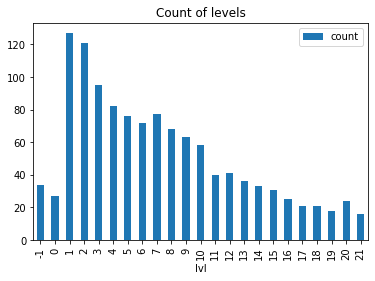

In [30]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [31]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [32]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [33]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [34]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [35]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [36]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.47


In [38]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [39]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

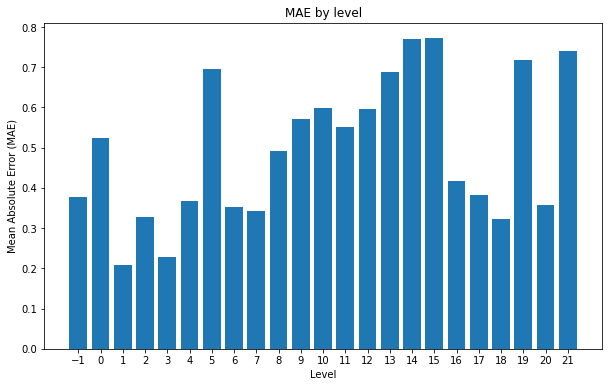

In [40]:
import matplotlib.pyplot as plt

y_test = y_test.reset_index(drop=True)
level_max = y_test.max()

mae_by_level = pd.DataFrame(columns=["level", "mae"])
for lvl in range(-1, level_max + 1):
    y_test_curr = y_test[y_test == lvl]
    y_pred_test_curr = pd.DataFrame(y_pred_test)[y_test == lvl]

    mae = mean_absolute_error(y_test_curr, y_pred_test_curr)
    mae_by_level.loc[lvl + 1] = [lvl, mae]


plt.figure(figsize=(10, 6))
plt.bar(mae_by_level["level"], mae_by_level["mae"])
plt.xlabel("Level")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE by level")
plt.xticks(mae_by_level["level"])
plt.show()

In [41]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



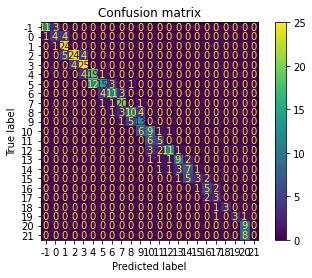

In [42]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [43]:
from training.results import assess_regression_model

In [44]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 22:04:13,822] A new study created in memory with name: no-name-0e297c6e-4030-46e7-8ee6-bca70fbf51d4
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.245718 + 0.054782
[200]	cv_agg's l2: 0.233173 + 0.0556408
[300]	cv_agg's l2: 0.229026 + 0.0546464
[400]	cv_agg's l2: 0.227947 + 0.0535149


feature_fraction, val_score: 0.227671:  14%|######4                                      | 1/7 [00:01<00:10,  1.82s/it]

Early stopping, best iteration is:
[394]	cv_agg's l2: 0.227671 + 0.0533879
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


feature_fraction, val_score: 0.227511:  29%|############8                                | 2/7 [00:03<00:07,  1.45s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.298754 + 0.0580949
[200]	cv_agg's l2: 0.260822 + 0.0512505


feature_fraction, val_score: 0.227511:  43%|###################2                         | 3/7 [00:04<00:05,  1.35s/it]

[300]	cv_agg's l2: 0.250211 + 0.049323
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.302564 + 0.0523563
[200]	cv_agg's l2: 0.266094 + 0.0517084


feature_fraction, val_score: 0.227511:  57%|#########################7                   | 4/7 [00:05<00:04,  1.35s/it]

[300]	cv_agg's l2: 0.254952 + 0.0529574
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.230699 + 0.0504399
[200]	cv_agg's l2: 0.228471 + 0.0524895


feature_fraction, val_score: 0.227511:  71%|################################1            | 5/7 [00:07<00:03,  1.63s/it]

[300]	cv_agg's l2: 0.229934 + 0.0534556
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


feature_fraction, val_score: 0.227511:  86%|######################################5      | 6/7 [00:10<00:01,  1.89s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.23413 + 0.0515182
[200]	cv_agg's l2: 0.232582 + 0.0496512


feature_fraction, val_score: 0.227511: 100%|#############################################| 7/7 [00:12<00:00,  1.81s/it]


[300]	cv_agg's l2: 0.234591 + 0.0510271
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:   5%|##5                                               | 1/20 [00:02<00:42,  2.26s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  10%|#####                                             | 2/20 [00:04<00:37,  2.09s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  15%|#######5                                          | 3/20 [00:05<00:31,  1.84s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  20%|##########                                        | 4/20 [00:07<00:27,  1.71s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  25%|############5                                     | 5/20 [00:08<00:25,  1.67s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  30%|###############                                   | 6/20 [00:10<00:22,  1.61s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.286447 + 0.0559545


num_leaves, val_score: 0.227511:  35%|#################5                                | 7/20 [00:10<00:15,  1.20s/it]

[200]	cv_agg's l2: 0.265185 + 0.0464584
[300]	cv_agg's l2: 0.257273 + 0.0407129
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  40%|####################                              | 8/20 [00:12<00:15,  1.28s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  45%|######################5                           | 9/20 [00:13<00:15,  1.37s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  50%|########################5                        | 10/20 [00:15<00:13,  1.37s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.335546 + 0.0493193


num_leaves, val_score: 0.227511:  55%|##########################9                      | 11/20 [00:15<00:09,  1.05s/it]

[200]	cv_agg's l2: 0.310358 + 0.0518375
[300]	cv_agg's l2: 0.305193 + 0.0544003
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  60%|#############################4                   | 12/20 [00:16<00:09,  1.18s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  65%|###############################8                 | 13/20 [00:18<00:09,  1.38s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  70%|##################################3              | 14/20 [00:20<00:08,  1.35s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  75%|####################################7            | 15/20 [00:21<00:06,  1.37s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  80%|#######################################2         | 16/20 [00:22<00:05,  1.38s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  85%|#########################################6       | 17/20 [00:24<00:04,  1.38s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  90%|############################################1    | 18/20 [00:25<00:02,  1.36s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511:  95%|##############################################5  | 19/20 [00:26<00:01,  1.37s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


num_leaves, val_score: 0.227511: 100%|#################################################| 20/20 [00:28<00:00,  1.41s/it]


[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005


bagging, val_score: 0.227511:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.24921 + 0.068284
[200]	cv_agg's l2: 0.245829 + 0.0683642


bagging, val_score: 0.227511:  10%|#####3                                               | 1/10 [00:01<00:12,  1.35s/it]

[300]	cv_agg's l2: 0.244376 + 0.0637088
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.315874 + 0.0921006
[200]	cv_agg's l2: 0.30517 + 0.0958075


bagging, val_score: 0.227511:  20%|##########6                                          | 2/10 [00:02<00:08,  1.10s/it]

[300]	cv_agg's l2: 0.308484 + 0.0843264
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.233573 + 0.0488954
[200]	cv_agg's l2: 0.228353 + 0.0487456


bagging, val_score: 0.227511:  30%|###############9                                     | 3/10 [00:03<00:08,  1.27s/it]

[300]	cv_agg's l2: 0.231472 + 0.0515046
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.296887 + 0.0861497
[200]	cv_agg's l2: 0.282894 + 0.0814731


bagging, val_score: 0.227511:  40%|#####################2                               | 4/10 [00:04<00:06,  1.08s/it]

[300]	cv_agg's l2: 0.279803 + 0.0787822
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.253155 + 0.0569629
[200]	cv_agg's l2: 0.244313 + 0.06128


bagging, val_score: 0.227511:  50%|##########################5                          | 5/10 [00:05<00:05,  1.08s/it]

[300]	cv_agg's l2: 0.244663 + 0.0641994
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.264725 + 0.0678231
[200]	cv_agg's l2: 0.251643 + 0.0697642


bagging, val_score: 0.227511:  60%|###############################8                     | 6/10 [00:06<00:04,  1.04s/it]

[300]	cv_agg's l2: 0.247692 + 0.071295
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.230822 + 0.0519149
[200]	cv_agg's l2: 0.228318 + 0.0522077


bagging, val_score: 0.227511:  70%|#####################################                | 7/10 [00:07<00:03,  1.15s/it]

[300]	cv_agg's l2: 0.230095 + 0.0530568
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.247831 + 0.0645158
[200]	cv_agg's l2: 0.241537 + 0.0606717


bagging, val_score: 0.227511:  80%|##########################################4          | 8/10 [00:09<00:02,  1.17s/it]

[300]	cv_agg's l2: 0.239659 + 0.057419
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.276957 + 0.058449
[200]	cv_agg's l2: 0.265278 + 0.057089


bagging, val_score: 0.227511:  90%|###############################################7     | 9/10 [00:10<00:01,  1.09s/it]

[300]	cv_agg's l2: 0.263695 + 0.0596573
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.269383 + 0.066953
[200]	cv_agg's l2: 0.264826 + 0.0700926


bagging, val_score: 0.227511: 100%|####################################################| 10/10 [00:11<00:00,  1.10s/it]


[300]	cv_agg's l2: 0.257276 + 0.0742617
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005


feature_fraction_stage2, val_score: 0.227511:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


feature_fraction_stage2, val_score: 0.227511:  17%|######3                               | 1/6 [00:01<00:06,  1.25s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


feature_fraction_stage2, val_score: 0.227511:  33%|############6                         | 2/6 [00:02<00:04,  1.17s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.231619 + 0.0508183
[200]	cv_agg's l2: 0.227511 + 0.0512005


feature_fraction_stage2, val_score: 0.227511:  50%|###################                   | 3/6 [00:03<00:03,  1.21s/it]

[300]	cv_agg's l2: 0.230452 + 0.0524283
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.245718 + 0.054782
[200]	cv_agg's l2: 0.233173 + 0.0556408


feature_fraction_stage2, val_score: 0.227511:  67%|#########################3            | 4/6 [00:04<00:02,  1.20s/it]

[300]	cv_agg's l2: 0.229026 + 0.0546464
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.245718 + 0.054782
[200]	cv_agg's l2: 0.233173 + 0.0556408


feature_fraction_stage2, val_score: 0.227511:  83%|###############################6      | 5/6 [00:06<00:01,  1.21s/it]

[300]	cv_agg's l2: 0.229026 + 0.0546464
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.245718 + 0.054782
[200]	cv_agg's l2: 0.233173 + 0.0556408


feature_fraction_stage2, val_score: 0.227511: 100%|######################################| 6/6 [00:07<00:00,  1.21s/it]


[300]	cv_agg's l2: 0.229026 + 0.0546464
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005


regularization_factors, val_score: 0.227511:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.232301 + 0.049978
[200]	cv_agg's l2: 0.228488 + 0.0484264


regularization_factors, val_score: 0.227511:   5%|#9                                    | 1/20 [00:01<00:24,  1.29s/it]

[300]	cv_agg's l2: 0.228874 + 0.048779
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.281629 + 0.0584477
[200]	cv_agg's l2: 0.278517 + 0.0587492
[300]	cv_agg's l2: 0.278517 + 0.0587498
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005


regularization_factors, val_score: 0.227511:  10%|###8                                  | 2/20 [00:01<00:14,  1.27it/s]

[100]	cv_agg's l2: 0.233293 + 0.0463915
[200]	cv_agg's l2: 0.22809 + 0.0454424


regularization_factors, val_score: 0.227511:  15%|#####7                                | 3/20 [00:02<00:17,  1.01s/it]

[300]	cv_agg's l2: 0.230045 + 0.0443476
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005
[100]	cv_agg's l2: 0.269577 + 0.0480118
[200]	cv_agg's l2: 0.266882 + 0.0483746
[300]	cv_agg's l2: 0.26688 + 0.048376
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.227511 + 0.0512005


regularization_factors, val_score: 0.227511:  20%|#######6                              | 4/20 [00:03<00:12,  1.28it/s]

[100]	cv_agg's l2: 0.238474 + 0.0469782
[200]	cv_agg's l2: 0.227818 + 0.0456549
[300]	cv_agg's l2: 0.228088 + 0.0449914


regularization_factors, val_score: 0.227412:  25%|#########5                            | 5/20 [00:04<00:15,  1.02s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.227412 + 0.0457035
[100]	cv_agg's l2: 0.233484 + 0.0494398
[200]	cv_agg's l2: 0.224344 + 0.0471727
[300]	cv_agg's l2: 0.221736 + 0.0448251


regularization_factors, val_score: 0.221617:  30%|###########4                          | 6/20 [00:06<00:17,  1.22s/it]

[400]	cv_agg's l2: 0.22354 + 0.046293
Early stopping, best iteration is:
[310]	cv_agg's l2: 0.221617 + 0.0449473
[100]	cv_agg's l2: 0.231314 + 0.0483659
[200]	cv_agg's l2: 0.226137 + 0.0479284
[300]	cv_agg's l2: 0.225823 + 0.046284


regularization_factors, val_score: 0.221617:  35%|#############3                        | 7/20 [00:08<00:17,  1.33s/it]

[400]	cv_agg's l2: 0.228308 + 0.0466822
Early stopping, best iteration is:
[310]	cv_agg's l2: 0.221617 + 0.0449473
[100]	cv_agg's l2: 0.230412 + 0.0413551
[200]	cv_agg's l2: 0.223847 + 0.0400016
[300]	cv_agg's l2: 0.224847 + 0.040114


regularization_factors, val_score: 0.221617:  40%|###############2                      | 8/20 [00:09<00:17,  1.45s/it]

[400]	cv_agg's l2: 0.226796 + 0.0411108
Early stopping, best iteration is:
[310]	cv_agg's l2: 0.221617 + 0.0449473
[100]	cv_agg's l2: 0.230168 + 0.0415483
[200]	cv_agg's l2: 0.221244 + 0.0422118
[300]	cv_agg's l2: 0.219543 + 0.0440753


regularization_factors, val_score: 0.219013:  45%|#################1                    | 9/20 [00:11<00:16,  1.50s/it]

[400]	cv_agg's l2: 0.219669 + 0.0447418
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.233712 + 0.0463932
[200]	cv_agg's l2: 0.225232 + 0.043645
[300]	cv_agg's l2: 0.22544 + 0.0435231


regularization_factors, val_score: 0.219013:  50%|##################5                  | 10/20 [00:12<00:15,  1.54s/it]

[400]	cv_agg's l2: 0.227023 + 0.0439022
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.233227 + 0.0439326
[200]	cv_agg's l2: 0.223215 + 0.044218
[300]	cv_agg's l2: 0.221457 + 0.042012


regularization_factors, val_score: 0.219013:  55%|####################3                | 11/20 [00:14<00:14,  1.56s/it]

[400]	cv_agg's l2: 0.222561 + 0.0417022
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.231103 + 0.0406161
[200]	cv_agg's l2: 0.221491 + 0.0392928
[300]	cv_agg's l2: 0.221016 + 0.0387331


regularization_factors, val_score: 0.219013:  60%|######################2              | 12/20 [00:16<00:12,  1.58s/it]

[400]	cv_agg's l2: 0.222313 + 0.0391631
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.230774 + 0.0480412
[200]	cv_agg's l2: 0.222639 + 0.0449871
[300]	cv_agg's l2: 0.222418 + 0.0442387


regularization_factors, val_score: 0.219013:  65%|########################             | 13/20 [00:17<00:11,  1.59s/it]

[400]	cv_agg's l2: 0.224735 + 0.0451688
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.230365 + 0.0415862
[200]	cv_agg's l2: 0.22118 + 0.0404635
[300]	cv_agg's l2: 0.220726 + 0.0397763


regularization_factors, val_score: 0.219013:  70%|#########################9           | 14/20 [00:19<00:09,  1.59s/it]

[400]	cv_agg's l2: 0.222617 + 0.0394658
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.235143 + 0.0459769
[200]	cv_agg's l2: 0.225338 + 0.0436451
[300]	cv_agg's l2: 0.224841 + 0.0425184


regularization_factors, val_score: 0.219013:  75%|###########################7         | 15/20 [00:21<00:07,  1.59s/it]

[400]	cv_agg's l2: 0.226609 + 0.0433919
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.229773 + 0.0491768
[200]	cv_agg's l2: 0.22687 + 0.0512581
[300]	cv_agg's l2: 0.228444 + 0.0524921


regularization_factors, val_score: 0.219013:  80%|#############################6       | 16/20 [00:22<00:06,  1.63s/it]

[400]	cv_agg's l2: 0.230356 + 0.0519395
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.231668 + 0.0522115
[200]	cv_agg's l2: 0.226661 + 0.0512843
[300]	cv_agg's l2: 0.230236 + 0.0501029


regularization_factors, val_score: 0.219013:  85%|###############################4     | 17/20 [00:24<00:04,  1.66s/it]

[400]	cv_agg's l2: 0.232874 + 0.0493817
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.230999 + 0.0471266
[200]	cv_agg's l2: 0.229745 + 0.0499548
[300]	cv_agg's l2: 0.231483 + 0.0501249


regularization_factors, val_score: 0.219013:  90%|#################################3   | 18/20 [00:26<00:03,  1.65s/it]

[400]	cv_agg's l2: 0.232277 + 0.0506591
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.235531 + 0.0511852
[200]	cv_agg's l2: 0.226602 + 0.0510567
[300]	cv_agg's l2: 0.226062 + 0.0499179


regularization_factors, val_score: 0.219013:  95%|###################################1 | 19/20 [00:27<00:01,  1.61s/it]

[400]	cv_agg's l2: 0.227939 + 0.0507554
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.228868 + 0.041496
[200]	cv_agg's l2: 0.221979 + 0.0399835
[300]	cv_agg's l2: 0.222036 + 0.0399961


regularization_factors, val_score: 0.219013: 100%|#####################################| 20/20 [00:29<00:00,  1.46s/it]


[400]	cv_agg's l2: 0.223127 + 0.0405873
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893


min_data_in_leaf, val_score: 0.219013:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.342009 + 0.0731977
[200]	cv_agg's l2: 0.329163 + 0.0720526
[300]	cv_agg's l2: 0.326794 + 0.0702998


min_data_in_leaf, val_score: 0.219013:  20%|#########                                    | 1/5 [00:00<00:03,  1.06it/s]

[400]	cv_agg's l2: 0.326568 + 0.0721299
Early stopping, best iteration is:
[306]	cv_agg's l2: 0.219013 + 0.0441893
[100]	cv_agg's l2: 0.201969 + 0.0405131
[200]	cv_agg's l2: 0.196995 + 0.0419929


min_data_in_leaf, val_score: 0.196641:  40%|##################                           | 2/5 [00:02<00:03,  1.29s/it]

[300]	cv_agg's l2: 0.197536 + 0.0431932
Early stopping, best iteration is:
[217]	cv_agg's l2: 0.196641 + 0.0422451
[100]	cv_agg's l2: 0.255143 + 0.0629831
[200]	cv_agg's l2: 0.251348 + 0.0607153


min_data_in_leaf, val_score: 0.196641:  60%|###########################                  | 3/5 [00:03<00:02,  1.16s/it]

[300]	cv_agg's l2: 0.249462 + 0.0618328
Early stopping, best iteration is:
[217]	cv_agg's l2: 0.196641 + 0.0422451
[100]	cv_agg's l2: 0.806346 + 0.164169
[200]	cv_agg's l2: 0.797638 + 0.166358


min_data_in_leaf, val_score: 0.196641:  80%|####################################         | 4/5 [00:03<00:00,  1.11it/s]

[300]	cv_agg's l2: 0.794561 + 0.171117
Early stopping, best iteration is:
[217]	cv_agg's l2: 0.196641 + 0.0422451
[100]	cv_agg's l2: 0.200363 + 0.0440347
[200]	cv_agg's l2: 0.19461 + 0.0465169


min_data_in_leaf, val_score: 0.194262: 100%|#############################################| 5/5 [00:05<00:00,  1.14s/it]

[300]	cv_agg's l2: 0.195454 + 0.0457777
Early stopping, best iteration is:
[221]	cv_agg's l2: 0.194262 + 0.0458945


In [45]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1942615572419897
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0027185351405794984
    lambda_l2: 8.387602236114686
    num_leaves: 31
    feature_fraction: 0.7
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [46]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [47]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.66
MSE test: 0.43
MAE test: 0.45



In [48]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [49]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.43
RMSE: 0.66

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.43
RMSE: 0.66

Round type: 0.45
MSE: 0.50
RMSE: 0.70



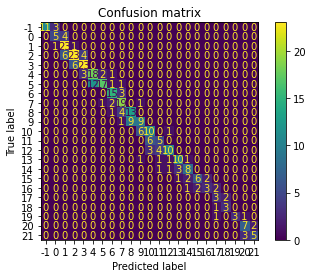

In [50]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [51]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.238538	valid_0's l1: 0.336785


In [52]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.34


In [54]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [55]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.26
RMSE: 0.51



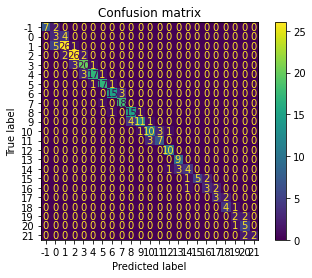

In [56]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [57]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 22:05:54,609] A new study created in memory with name: no-name-ff15e2b1-2fe4-4369-8b74-289ad37fc3da
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.244014 + 0.065734


feature_fraction, val_score: 0.243837:  14%|######4                                      | 1/7 [00:00<00:05,  1.05it/s]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.315771 + 0.0351259


feature_fraction, val_score: 0.243837:  29%|############8                                | 2/7 [00:01<00:04,  1.02it/s]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.314013 + 0.0332504


feature_fraction, val_score: 0.243837:  43%|###################2                         | 3/7 [00:02<00:03,  1.06it/s]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.251098 + 0.0700757


feature_fraction, val_score: 0.243837:  57%|#########################7                   | 4/7 [00:03<00:02,  1.05it/s]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.244014 + 0.065734


feature_fraction, val_score: 0.243837:  71%|################################1            | 5/7 [00:04<00:01,  1.05it/s]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.281524 + 0.0543625


feature_fraction, val_score: 0.243837:  86%|######################################5      | 6/7 [00:05<00:00,  1.06it/s]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.256299 + 0.0777865


feature_fraction, val_score: 0.243837: 100%|#############################################| 7/7 [00:06<00:00,  1.06it/s]


Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136


num_leaves, val_score: 0.243837:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244014 + 0.065734


num_leaves, val_score: 0.243837:   5%|##5                                               | 1/20 [00:01<00:22,  1.20s/it]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.249934 + 0.0674471


num_leaves, val_score: 0.243837:  10%|#####                                             | 2/20 [00:02<00:19,  1.07s/it]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.244014 + 0.065734


num_leaves, val_score: 0.243837:  15%|#######5                                          | 3/20 [00:03<00:18,  1.07s/it]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.243837 + 0.0653136
[100]	cv_agg's l2: 0.244814 + 0.0665501


num_leaves, val_score: 0.241038:  20%|##########                                        | 4/20 [00:03<00:13,  1.15it/s]

[200]	cv_agg's l2: 0.242597 + 0.0628323
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956


num_leaves, val_score: 0.241038:  25%|############5                                     | 5/20 [00:04<00:10,  1.50it/s]

[100]	cv_agg's l2: 0.323747 + 0.0877215
[200]	cv_agg's l2: 0.284658 + 0.0779889
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  30%|###############                                   | 6/20 [00:05<00:12,  1.10it/s]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  35%|#################5                                | 7/20 [00:06<00:12,  1.01it/s]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  40%|####################                              | 8/20 [00:07<00:12,  1.06s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  45%|######################5                           | 9/20 [00:09<00:12,  1.15s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  50%|########################5                        | 10/20 [00:10<00:11,  1.17s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  55%|##########################9                      | 11/20 [00:11<00:10,  1.17s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  60%|#############################4                   | 12/20 [00:13<00:09,  1.25s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.323747 + 0.0877215


num_leaves, val_score: 0.241038:  65%|###############################8                 | 13/20 [00:13<00:06,  1.05it/s]

[200]	cv_agg's l2: 0.284658 + 0.0779889
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  70%|##################################3              | 14/20 [00:14<00:06,  1.11s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  75%|####################################7            | 15/20 [00:15<00:05,  1.14s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  80%|#######################################2         | 16/20 [00:17<00:04,  1.16s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  85%|#########################################6       | 17/20 [00:18<00:03,  1.21s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  90%|############################################1    | 18/20 [00:19<00:02,  1.20s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038:  95%|##############################################5  | 19/20 [00:20<00:01,  1.21s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.244014 + 0.065734
[200]	cv_agg's l2: 0.247977 + 0.0640619


num_leaves, val_score: 0.241038: 100%|#################################################| 20/20 [00:22<00:00,  1.11s/it]


Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956


bagging, val_score: 0.241038:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.256294 + 0.0660661


bagging, val_score: 0.241038:  10%|#####3                                               | 1/10 [00:00<00:06,  1.48it/s]

[200]	cv_agg's l2: 0.25545 + 0.0642336
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.311342 + 0.0609106


bagging, val_score: 0.241038:  20%|##########6                                          | 2/10 [00:01<00:05,  1.47it/s]

[200]	cv_agg's l2: 0.303936 + 0.0589823
Early stopping, best iteration is:
[152]	cv_agg's l2: 0.241038 + 0.0631956
[100]	cv_agg's l2: 0.246493 + 0.0676508
[200]	cv_agg's l2: 0.239902 + 0.064661


bagging, val_score: 0.237530:  30%|###############9                                     | 3/10 [00:02<00:05,  1.28it/s]

[300]	cv_agg's l2: 0.240026 + 0.0627681
Early stopping, best iteration is:
[254]	cv_agg's l2: 0.23753 + 0.0636318
[100]	cv_agg's l2: 0.247665 + 0.0677198
[200]	cv_agg's l2: 0.244117 + 0.0601886


bagging, val_score: 0.237530:  40%|#####################2                               | 4/10 [00:03<00:05,  1.19it/s]

[300]	cv_agg's l2: 0.24571 + 0.0608776
Early stopping, best iteration is:
[254]	cv_agg's l2: 0.23753 + 0.0636318
[100]	cv_agg's l2: 0.244814 + 0.0665501
[200]	cv_agg's l2: 0.242597 + 0.0628323


bagging, val_score: 0.237530:  50%|##########################5                          | 5/10 [00:04<00:04,  1.16it/s]

[300]	cv_agg's l2: 0.242083 + 0.0617355
Early stopping, best iteration is:
[254]	cv_agg's l2: 0.23753 + 0.0636318
[100]	cv_agg's l2: 0.244814 + 0.0665501
[200]	cv_agg's l2: 0.242597 + 0.0628323


bagging, val_score: 0.237530:  60%|###############################8                     | 6/10 [00:05<00:03,  1.13it/s]

[300]	cv_agg's l2: 0.242083 + 0.0617355
Early stopping, best iteration is:
[254]	cv_agg's l2: 0.23753 + 0.0636318
[100]	cv_agg's l2: 0.24395 + 0.0644607
[200]	cv_agg's l2: 0.239279 + 0.0594533


bagging, val_score: 0.237530:  70%|#####################################                | 7/10 [00:05<00:02,  1.14it/s]

[300]	cv_agg's l2: 0.239496 + 0.0579818
Early stopping, best iteration is:
[254]	cv_agg's l2: 0.23753 + 0.0636318
[100]	cv_agg's l2: 0.240738 + 0.0583625


bagging, val_score: 0.233589:  70%|#####################################                | 7/10 [00:06<00:02,  1.14it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


bagging, val_score: 0.233589:  80%|##########################################4          | 8/10 [00:06<00:01,  1.15it/s]

[100]	cv_agg's l2: 0.250189 + 0.0663836


bagging, val_score: 0.233589:  90%|###############################################7     | 9/10 [00:07<00:00,  1.23it/s][I 2023-10-28 22:06:30,811] Trial 35 finished with value: 0.2446883121034397 and parameters: {'bagging_fraction': 0.8892029575761708, 'bagging_freq': 5}. Best is trial 34 with value: 0.23358909735500158.


[200]	cv_agg's l2: 0.246119 + 0.0628559
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


bagging, val_score: 0.233589:  90%|###############################################7     | 9/10 [00:07<00:00,  1.23it/s]

[100]	cv_agg's l2: 0.249951 + 0.05595


bagging, val_score: 0.233589: 100%|####################################################| 10/10 [00:08<00:00,  1.23it/s]


[200]	cv_agg's l2: 0.245289 + 0.0546478
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


feature_fraction_stage2, val_score: 0.233589:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


feature_fraction_stage2, val_score: 0.233589:   0%|                                              | 0/6 [00:00<?, ?it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


feature_fraction_stage2, val_score: 0.233589:  17%|######3                               | 1/6 [00:00<00:03,  1.45it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


feature_fraction_stage2, val_score: 0.233589:  33%|############6                         | 2/6 [00:01<00:02,  1.37it/s][I 2023-10-28 22:06:32,998] Trial 38 finished with value: 0.23358909735500158 and parameters: {'feature_fraction': 0.716}. Best is trial 37 with value: 0.23358909735500158.


[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


feature_fraction_stage2, val_score: 0.233589:  33%|############6                         | 2/6 [00:01<00:02,  1.37it/s]

[100]	cv_agg's l2: 0.267473 + 0.0620666


feature_fraction_stage2, val_score: 0.233589:  33%|############6                         | 2/6 [00:02<00:02,  1.37it/s]

[200]	cv_agg's l2: 0.24841 + 0.0564938
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


feature_fraction_stage2, val_score: 0.233589:  50%|###################                   | 3/6 [00:02<00:02,  1.36it/s]

[100]	cv_agg's l2: 0.267473 + 0.0620666


feature_fraction_stage2, val_score: 0.233589:  50%|###################                   | 3/6 [00:02<00:02,  1.36it/s]

[200]	cv_agg's l2: 0.24841 + 0.0564938
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


feature_fraction_stage2, val_score: 0.233589:  67%|#########################3            | 4/6 [00:02<00:01,  1.35it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


feature_fraction_stage2, val_score: 0.233589:  83%|###############################6      | 5/6 [00:03<00:00,  1.41it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.267473 + 0.0620666


feature_fraction_stage2, val_score: 0.233589: 100%|######################################| 6/6 [00:04<00:00,  1.41it/s]


[200]	cv_agg's l2: 0.24841 + 0.0564938
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:   0%|                                              | 0/20 [00:00<?, ?it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:   5%|#9                                    | 1/20 [00:00<00:13,  1.45it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:   5%|#9                                    | 1/20 [00:01<00:13,  1.45it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  10%|###8                                  | 2/20 [00:01<00:13,  1.38it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  10%|###8                                  | 2/20 [00:02<00:13,  1.38it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  15%|#####7                                | 3/20 [00:02<00:12,  1.37it/s]

[100]	cv_agg's l2: 0.254068 + 0.0711253


regularization_factors, val_score: 0.233589:  15%|#####7                                | 3/20 [00:02<00:12,  1.37it/s]

[200]	cv_agg's l2: 0.248763 + 0.0694269
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  20%|#######6                              | 4/20 [00:02<00:11,  1.34it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  25%|#########5                            | 5/20 [00:03<00:10,  1.37it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  30%|###########4                          | 6/20 [00:04<00:10,  1.38it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  30%|###########4                          | 6/20 [00:05<00:10,  1.38it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  35%|#############3                        | 7/20 [00:05<00:09,  1.37it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  40%|###############2                      | 8/20 [00:05<00:08,  1.39it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  45%|#################1                    | 9/20 [00:06<00:08,  1.37it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  45%|#################1                    | 9/20 [00:07<00:08,  1.37it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  50%|##################5                  | 10/20 [00:07<00:07,  1.37it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  55%|####################3                | 11/20 [00:08<00:06,  1.36it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  60%|######################2              | 12/20 [00:08<00:05,  1.38it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  60%|######################2              | 12/20 [00:09<00:05,  1.38it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  65%|########################             | 13/20 [00:09<00:05,  1.37it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  65%|########################             | 13/20 [00:10<00:05,  1.37it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  70%|#########################9           | 14/20 [00:10<00:04,  1.35it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  75%|###########################7         | 15/20 [00:10<00:03,  1.36it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


[I 2023-10-28 22:06:46,767] Trial 57 finished with value: 0.23358903285886984 and parameters: {'lambda_l1': 1.028209916846971e-08, 'lambda_l2': 0.00013356797694242544}. Best is trial 57 with value: 0.23358903285886984.
regularization_factors, val_score: 0.233589:  75%|###########################7         | 15/20 [00:10<00:03,  1.36it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583624


regularization_factors, val_score: 0.233589:  80%|#############################6       | 16/20 [00:11<00:02,  1.37it/s][I 2023-10-28 22:06:47,483] Trial 58 finished with value: 0.23409018716961544 and parameters: {'lambda_l1': 8.023850558245439e-07, 'lambda_l2': 0.00041567819251807895}. Best is trial 57 with value: 0.23358903285886984.


[200]	cv_agg's l2: 0.235 + 0.0562873
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


regularization_factors, val_score: 0.233589:  80%|#############################6       | 16/20 [00:11<00:02,  1.37it/s]

[100]	cv_agg's l2: 0.240738 + 0.0583624


regularization_factors, val_score: 0.233589:  85%|###############################4     | 17/20 [00:12<00:02,  1.38it/s]

[200]	cv_agg's l2: 0.235 + 0.0562873
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  90%|#################################3   | 18/20 [00:13<00:01,  1.39it/s]

[200]	cv_agg's l2: 0.235 + 0.0562873
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583625


regularization_factors, val_score: 0.233589:  95%|###################################1 | 19/20 [00:13<00:00,  1.39it/s]

[200]	cv_agg's l2: 0.234791 + 0.0559008
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.240738 + 0.0583624


regularization_factors, val_score: 0.233589: 100%|#####################################| 20/20 [00:14<00:00,  1.32it/s]

[200]	cv_agg's l2: 0.235 + 0.0562873
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


[I 2023-10-28 22:06:50,469] Trial 62 finished with value: 0.234090322455911 and parameters: {'lambda_l1': 1.0550677018242541e-07, 'lambda_l2': 0.00014816025316394406}. Best is trial 57 with value: 0.23358903285886984.
min_data_in_leaf, val_score: 0.233589:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.339926 + 0.0945044


min_data_in_leaf, val_score: 0.233589:  20%|#########                                    | 1/5 [00:00<00:02,  1.44it/s]

[200]	cv_agg's l2: 0.335893 + 0.0855783
Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305


[I 2023-10-28 22:06:51,171] Trial 63 finished with value: 0.3367400322198426 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.3367400322198426.
min_data_in_leaf, val_score: 0.233589:  20%|#########                                    | 1/5 [00:00<00:02,  1.44it/s]

[100]	cv_agg's l2: 0.824958 + 0.07797
[200]	cv_agg's l2: 0.798208 + 0.0849792


min_data_in_leaf, val_score: 0.233589:  40%|##################                           | 2/5 [00:01<00:01,  1.64it/s]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.233589 + 0.0566305
[100]	cv_agg's l2: 0.223575 + 0.0620636
[200]	cv_agg's l2: 0.2195 + 0.0583161


min_data_in_leaf, val_score: 0.218177:  60%|###########################                  | 3/5 [00:02<00:01,  1.44it/s]

[300]	cv_agg's l2: 0.219317 + 0.0554772
Early stopping, best iteration is:
[224]	cv_agg's l2: 0.218177 + 0.0572032
[100]	cv_agg's l2: 0.230201 + 0.067061
[200]	cv_agg's l2: 0.225857 + 0.0597439


min_data_in_leaf, val_score: 0.218177:  80%|####################################         | 4/5 [00:02<00:00,  1.36it/s]

[300]	cv_agg's l2: 0.228606 + 0.0578938
Early stopping, best iteration is:
[224]	cv_agg's l2: 0.218177 + 0.0572032
[100]	cv_agg's l2: 0.265553 + 0.0727211
[200]	cv_agg's l2: 0.265102 + 0.0744269


min_data_in_leaf, val_score: 0.218177: 100%|#############################################| 5/5 [00:03<00:00,  1.30it/s]

[300]	cv_agg's l2: 0.265294 + 0.0739907
Early stopping, best iteration is:
[224]	cv_agg's l2: 0.218177 + 0.0572032


In [58]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.21817728087148466
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.028209916846971e-08
    lambda_l2: 0.00013356797694242544
    num_leaves: 9
    feature_fraction: 0.7
    bagging_fraction: 0.9924820716277776
    bagging_freq: 7
    min_child_samples: 5


In [59]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [60]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.48
MSE test: 0.23
MAE test: 0.31



In [61]:
results.loc[4] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

In [62]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.10
RMSE: 0.32

Round type: round
MSE: 0.11
RMSE: 0.33

Round type: 0.33
MSE: 0.12
RMSE: 0.35

Round type: 0.45
MSE: 0.12
RMSE: 0.34



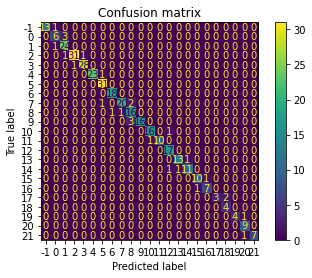

In [63]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [64]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,0.447566,0.669004,0.467604
1,chronological,Optuna,8,0.430300,0.655973,0.451230
3,random,normal,8,0.238538,0.488404,0.336785
4,random,Optuna,8,0.231122,0.480751,0.312252


In [65]:
from training.results import plot_summary

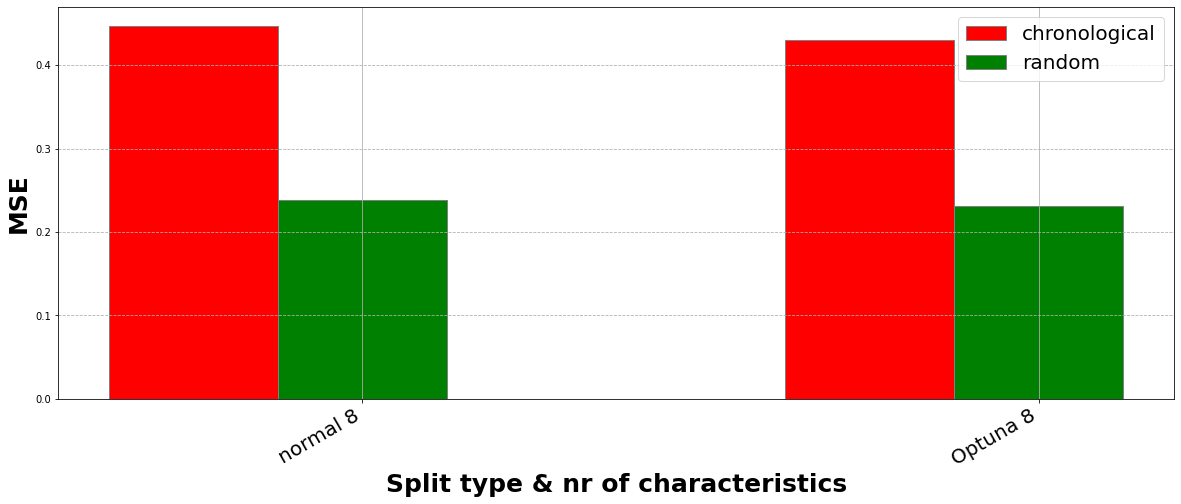

In [66]:
plot_summary(results, "MSE")

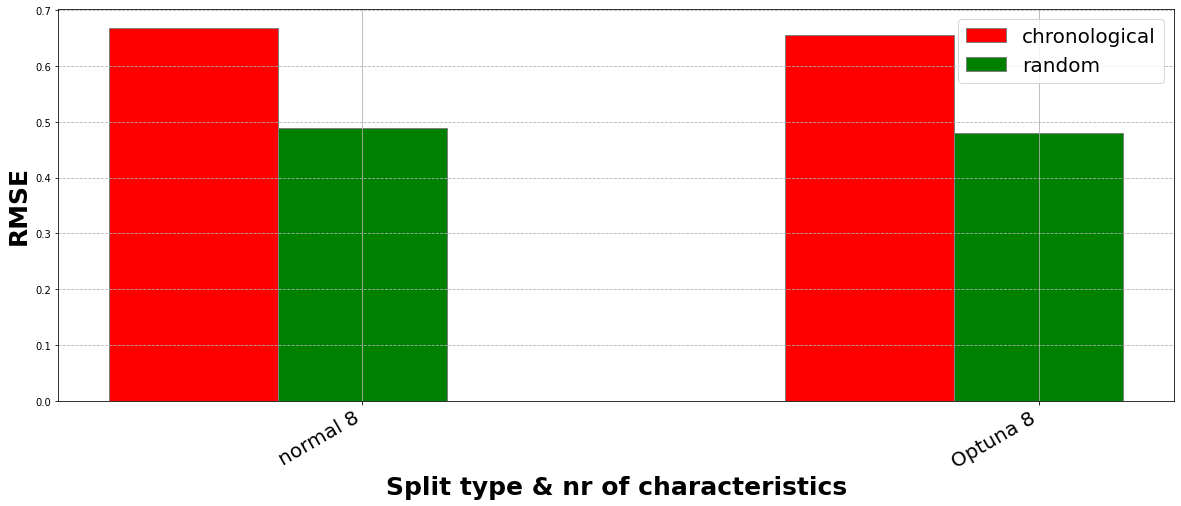

In [67]:
plot_summary(results, "RMSE")

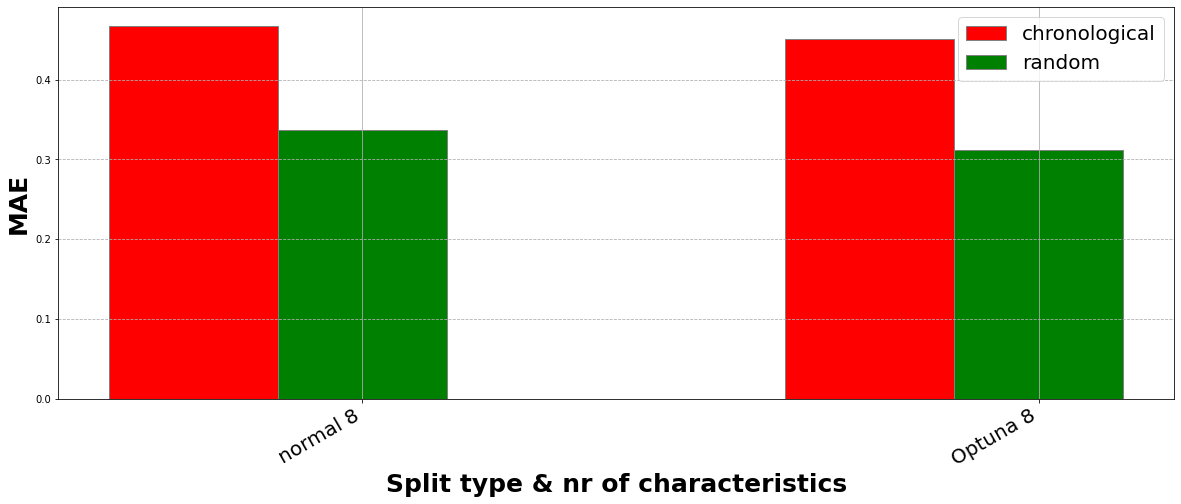

In [68]:
plot_summary(results, "MAE")

In [69]:
results.to_json("./lightgbm_basic_results.json")